In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pysam, sys, pickle
from dataclasses import dataclass
from copy import deepcopy
from Bio.Seq import Seq
from Bio import SeqIO
from matplotlib.gridspec import GridSpec
from scipy.signal import savgol_filter
from fuzzysearch import find_near_matches
from scipy import stats

sys.path.append('../scripts')
from process_reads import *
from analysis_functions import *

pd.set_option('mode.chained_assignment', None)

@dataclass
class read_part:
    cigar: str
    read_start: int
    read_end: int
    chrom: str=''
    strand: chr=''
    ref_start: int = -1
    ref_end: int = -1
    mapq: int = -1
    
    def get_length(self):
        return self.read_end-self.read_start

In [3]:
template = list(SeqIO.parse('references/220416_template.fa', format='fasta'))[0]
template = str(template.seq).upper()
transgene_len = len(template)

template_flanks = list(SeqIO.parse('references/220416_template+rDNAflanks.fa', format='fasta'))[0]
transgene_ref = template_flanks.name
template_flanks = str(template_flanks.seq).upper()

rDNA_repeat = list(SeqIO.parse('references/rDNA_fullrepeat.fa', format='fasta'))[0]
rDNA_ref = rDNA_repeat.name
rDNA_repeat = str(rDNA_repeat.seq)

flank_len = 840
upstream_rDNA = 28
end = flank_len+transgene_len

with open('KCXZ0001A_reads.pkl', 'rb') as f:
    read_dict = pickle.load(f)
    
prefix = 'ZoAl_CBh'

# plot coverage

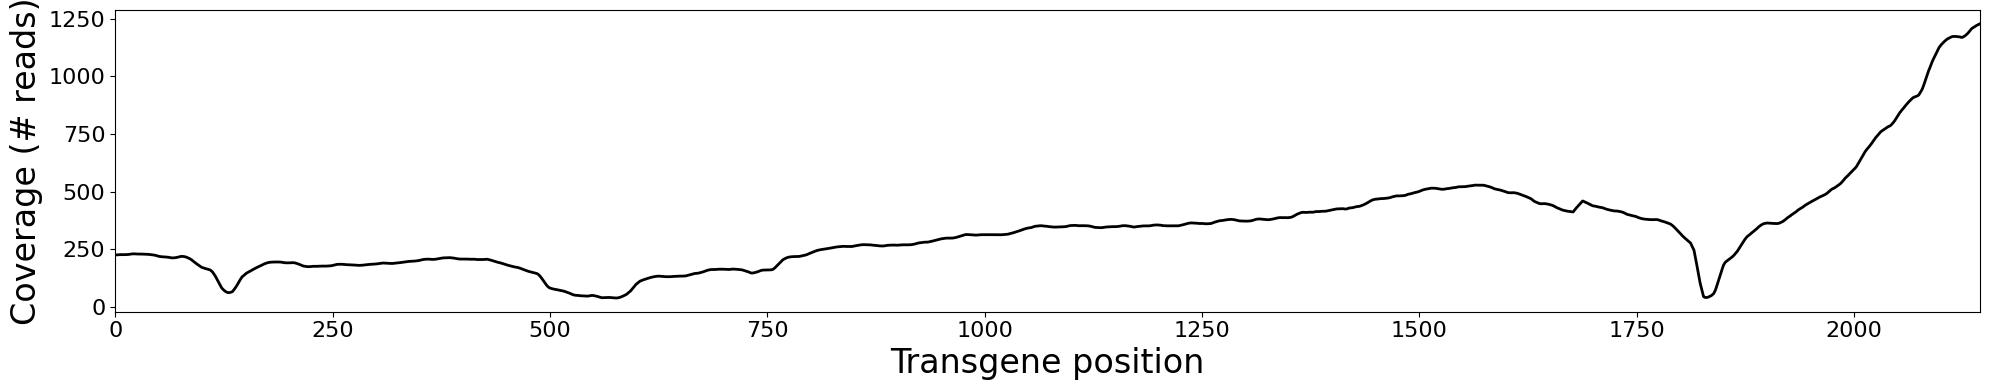

In [5]:
y = get_transgene_coverage(read_dict, transgene_ref, transgene_len)

fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)
ax.plot(range(transgene_len-1), savgol_filter(y,11,1), c='k', lw=2)
ax.set_xlim((0,transgene_len-2))

ax.tick_params(labelsize=16)
ax.set_ylabel('Coverage (# reads)', fontsize=24)
ax.set_xlabel('Transgene position', fontsize=24)

fig.tight_layout()
fig.savefig('plots/%s_transgene_coverage.png' % prefix)
fig.savefig('plots/%s_transgene_coverage.eps' % prefix)

# junction types
- **Type I:** match-match
- **Type II:** match-unmapped-match (maybe match-insertion-match?)
- **Type III:** match-unmapped or unmapped-match
- **Type IV:** match crosses transgene start or end

In [7]:
typeI, typeII, typeIIb, typeIIIa, typeIIIb, typeIVa, typeIVb = classify_junctions(read_dict, transgene_ref, transgene_len)

# plot gaps

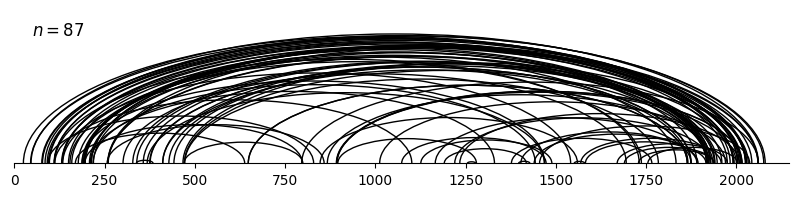

In [8]:
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(111)

plot_gapped_insertions(ax,read_dict,typeI,transgene_ref, transgene_len);

fig.savefig('plots/%s_gaps.eps' % prefix)
fig.savefig('plots/%s_gaps.png' % prefix)

# Type I and II analysis

In [9]:
same_strand, ss_other, opposite_strand, os_other = classify_typeI_typeII(typeI, read_dict, transgene_ref, transgene_len)

temp_ss, ss_other, temp_os, os_other = classify_typeI_typeII(typeII, read_dict, transgene_ref, transgene_len)
same_strand.update(temp_ss)
opposite_strand.update(temp_os)

temp_ss, ss_other, temp_os, os_other = classify_typeI_typeII(typeIIb, read_dict, transgene_ref, transgene_len)
same_strand.update(temp_ss)
opposite_strand.update(temp_os)

# analyze 5' junctions

In [11]:
# classify junctions

_5p_junctions = {}
tg_start_sites = []

for matepair in typeIVa:
    read, part = typeIVa[matepair]
    entry = read_dict[matepair][read][part]
    tg_start_sites.append(flank_len)
    
    if entry.ref_start < (flank_len-36):
        _5p_junctions[matepair] = 'FL_anneal'
        
    else: #elif part=='pt1': <-- if there's other stuff upstream, it should have been taken care of by other code
        _5p_junctions[matepair] = 'FL_indeterminate'
        
        
classification_temp, rDNA_join_sites, tg_start_temp = classify_5p_junctions(read_dict, same_strand)
_5p_junctions.update(classification_temp)
tg_start_sites += tg_start_temp

classification_temp, rDNA_join_temp, tg_start_temp = classify_5p_junctions(read_dict, opposite_strand)
_5p_junctions.update(classification_temp)
rDNA_join_sites['FL'].extend(rDNA_join_temp['FL'])
rDNA_join_sites['Trunc'].extend(rDNA_join_temp['Trunc'])
tg_start_sites += tg_start_temp

# save join sites to file
np.save('out/%s_FL_joinsites.npy' % prefix, rDNA_join_sites['FL'])
np.save('out/%s_T_joinsites.npy' % prefix, rDNA_join_sites['Trunc'])

A00887:503:HY5W3DSX3:4:1626:15383:36057 chr21


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


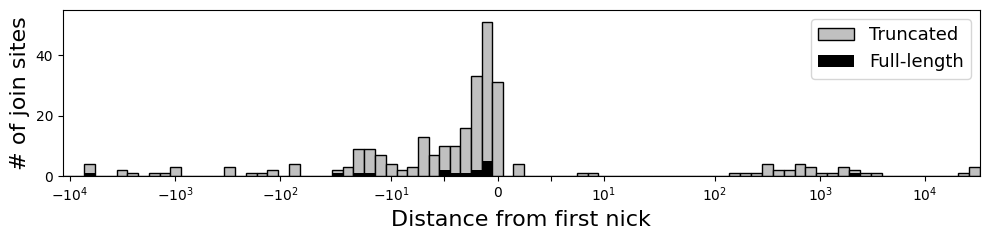

In [13]:
offset = 11679
nickdist_FL = [x-offset for x in rDNA_join_sites['FL']]
nickdist_Trunc = [x-offset for x in rDNA_join_sites['Trunc']]
nickdist_all = np.hstack([nickdist_FL, nickdist_Trunc])

fig = plt.figure(figsize=(10,2.5))
bins = np.hstack([np.geomspace(-offset,-12.5,30),np.arange(-10.5,12)[:-1],np.geomspace(12.5,44838-offset,34)])


ax = fig.add_subplot(111)
ax.hist(nickdist_all, bins=bins, fc='silver', ec='k')
ax.hist(nickdist_FL, bins=bins, fc='k')
ax.set_xscale('symlog', linthresh=11)
ax.set_ylim(0,55)
ax.set_xticks([-1e4,-1e3,-1e2,-1e1,-5,0,5,1e1,1e2,1e3,1e4])
ax.set_xlim(-offset,44838-offset)
ax.legend(['Truncated', 'Full-length'], fontsize=13)
ax.set_ylabel('# of join sites', fontsize=16)
ax.set_xlabel('Distance from first nick', fontsize=16)

fig.tight_layout()
fig.savefig('plots/%s_joinsites.eps' % prefix)
fig.savefig('plots/%s_joinsites.png' % prefix)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


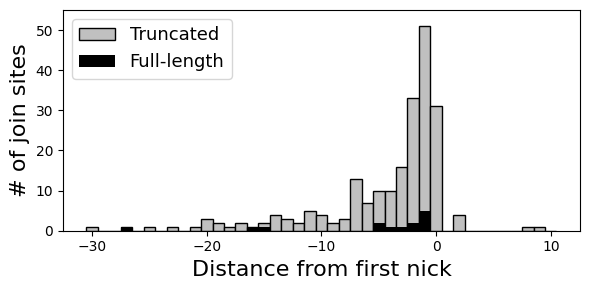

In [15]:

fig = plt.figure(figsize=(6,3))
bins = np.arange(-30.5,11)


ax = fig.add_subplot(111)
ax.hist(nickdist_all, bins=bins, fc='silver', ec='k')
ax.hist(nickdist_FL, bins=bins, fc='k')
# ax.set_xscale('symlog', linthresh=11)
ax.set_ylim(0,55)
# ax.set_xticks([-1e4,-1e3,-1e2,-1e1,-5,0,5,1e1,1e2,1e3,1e4])
# ax.set_xlim(-offset,44838-offset)
ax.legend(['Truncated', 'Full-length'], fontsize=13)
ax.set_ylabel('# of join sites', fontsize=16)
ax.set_xlabel('Distance from first nick', fontsize=16)

fig.tight_layout()
fig.savefig('plots/%s_joinsites_linear.eps' % prefix)
fig.savefig('plots/%s_joinsites_linear.png' % prefix)

# analyze 3' junctions

In [15]:
# classify 3' junctions from type I junctions
_3p_junctions, initiation_sites, IVS, uncertain = classify_3p_junctions(read_dict, same_strand, transgene_len)

# classify 3' junctions from type II junctions
classification_temp, initiation_temp, IVS_temp, uncertain_temp = classify_3p_junctions(read_dict, opposite_strand, transgene_len)
_3p_junctions.update(classification_temp)
initiation_sites += initiation_temp
IVS.update(IVS_temp)
uncertain.update(uncertain_temp)

# classify 3' junctions from type IV junctions
classification_temp, initiation_temp, IVS_temp = classify_typeIVb_junctions(read_dict, typeIVb, end)
_3p_junctions.update(classification_temp)
initiation_sites += initiation_temp
IVS.update(IVS_temp)

# 3' junctions

In [18]:
Counter(IVS.values())

Counter({'GAAAAAGGTAGC': 1,
         'GAAAAAAGTAGC': 11,
         'GAAAAAGTAGC': 9,
         'GAAAATAAAAAAAAAAAAAAAAAAGTAGC': 1,
         'GAAAAAAAAGTAGC': 1,
         'GAAAATAGC': 1112,
         'GAAAGTAGC': 8,
         'GAAACGAGC': 1,
         'AAAAATAGC': 1,
         'GAAAATAGT': 1,
         'GAAAATAGA': 1,
         'GAAGATAGC': 1})

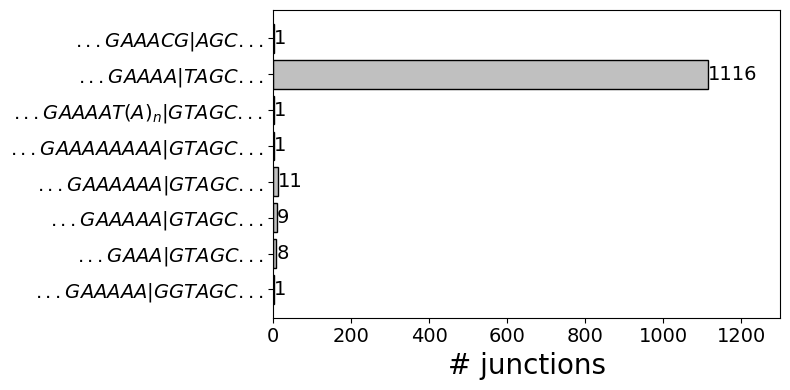

In [19]:
# manual assessment of categories
h = [len([x for x in IVS if IVS[x] in ['GAAAAAGGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAAAAAAAAAAAAAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAGC','GAAAAAAGC','AAAAATAGC','GAAAATAGT','GAAAATAGA','GAAGATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAACGAGC']])]
labels = ['$...GAAAAA|GGTAGC...$',
          '$...GAAA|GTAGC...$',
          '$...GAAAAA|GTAGC...$',
          '$...GAAAAAA|GTAGC...$',
          '$...GAAAAAAAA|GTAGC...$',
          '$...GAAAAT(A)_n|GTAGC...$',
          '$...GAAAA|TAGC...$',
          '$...GAAACG|AGC...$']

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

bars = ax.barh(np.arange(len(h)),h, ec='k', fc='silver')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(0,1300)
# ax.set_yscale('log')

ax.set_yticks(np.arange(len(h)), labels)
# ax.set_yticklabels(labels)

ax.tick_params(labelsize=14)
ax.set_xlabel('# junctions', fontsize=20)

fig.tight_layout()
fig.savefig('plots/%s_3pjunction_detail.eps' % prefix)
fig.savefig('plots/%s_3pjunction_detail.png' % prefix)

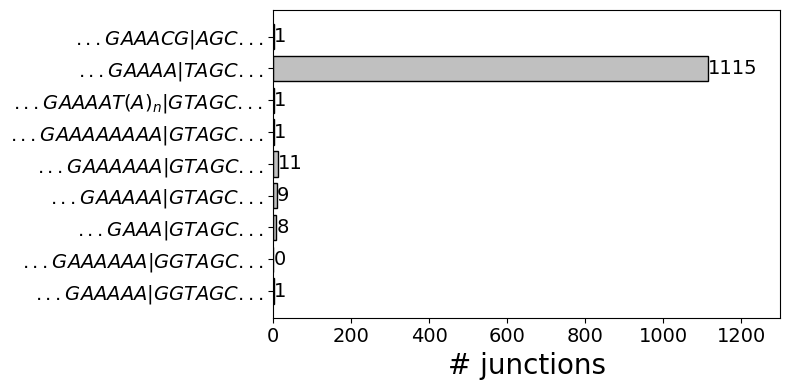

In [20]:
# manual assessment of categories
h = [len([x for x in IVS if IVS[x] in ['GAAAAAGGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAGGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAAAAAAAAAAAAAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAGC','GAAAAAAGC','AAAAATAGC','GAAAATAGT','GAAAATAGA','GACAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAACGAGC']])]
labels = ['$...GAAAAA|GGTAGC...$',
          '$...GAAAAAA|GGTAGC...$',
          '$...GAAA|GTAGC...$',
          '$...GAAAAA|GTAGC...$',
          '$...GAAAAAA|GTAGC...$',
          '$...GAAAAAAAA|GTAGC...$',
          '$...GAAAAT(A)_n|GTAGC...$',
          '$...GAAAA|TAGC...$',
          '$...GAAACG|AGC...$']

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

bars = ax.barh(np.arange(len(h)),h, ec='k', fc='silver')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(0,1300)
# ax.set_yscale('log')

ax.set_yticks(np.arange(len(h)), labels)
# ax.set_yticklabels(labels)

ax.tick_params(labelsize=14)
ax.set_xlabel('# junctions', fontsize=20)

fig.tight_layout()
fig.savefig('plots/%s_3pjunction_detail.eps' % prefix)
fig.savefig('plots/%s_3pjunction_detail.png' % prefix)

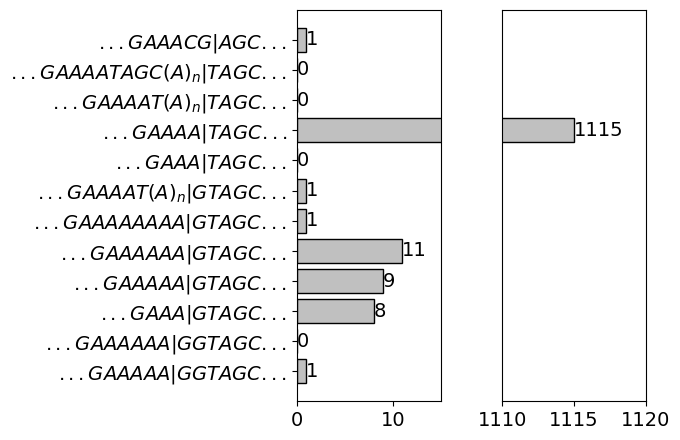

In [21]:
# manual assessment of categories
h = [len([x for x in IVS if IVS[x] in ['GAAAAAGGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAGGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAAAAAAGTAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAAAAAAAAAAGTAGC','GAAAATAAAAAAAAAAAAGTAGC','GAAAATAAAAAAAAAAAAAAAAAAGTAGC','GAAAATAAAAATAGC','GAAAATAAAAAAAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAGC','GAAAATATC','GAAAAAAGC','AAAAATAGC','GAAAATGGC','GAAAATAGT','GAAAATAGA','GACAATAGC', 'GAACATAGC', 'GAATATAGC','GAAATTAGC','TAAAATAGC','GAAAATAGA']]),
     # len([x for x in IVS if IVS[x] in ['GAAAAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAAAAAAAAATAGC','GAAAATAAAAAAATAGC','GAAAATAAAAAATAGC','GAAAATAAAAAAAAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAAATAGCAAAAAATAGC','GAAAATAGCAAAAAAAAATAGC','GAAAATAGCAAAAAAAAAAATAGC','GAAAATAGCAAAAAAATAGC','GAAAATAGCAAAAAAAATAGC','GAAAATAGCAAAAAAAAAAATAGC','GAAAATAGCAAAAAAAAAAAAAAATAGC']]),
     len([x for x in IVS if IVS[x] in ['GAAACGAGC']])]
labels = ['$...GAAAAA|GGTAGC...$',
          '$...GAAAAAA|GGTAGC...$',
          '$...GAAA|GTAGC...$',
          '$...GAAAAA|GTAGC...$',
          '$...GAAAAAA|GTAGC...$',
          '$...GAAAAAAAA|GTAGC...$',
          '$...GAAAAT(A)_n|GTAGC...$',
          '$...GAAA|TAGC...$',
          '$...GAAAA|TAGC...$',
          # '$...GAAAAA|TAGC...$',
          '$...GAAAAT(A)_n|TAGC...$',
          '$...GAAAATAGC(A)_n|TAGC...$',
          '$...GAAACG|AGC...$']

fig = plt.figure(figsize=(7,4.5))


ax = fig.add_subplot(121)
bars = ax.barh(np.arange(len(h)),h, ec='k', fc='silver')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(0,15)
ax.set_yticks(np.arange(len(h)), labels)
ax.tick_params(labelsize=14)

ax = fig.add_subplot(122)
bars = ax.barh(np.arange(len(h)),h, ec='k', fc='silver')
ax.bar_label(bars, fontsize=14)
ax.set_xlim(1110,1120)
ax.set_yticks([])
ax.tick_params(labelsize=14)

# fig.supxlabel('# junctions', fontsize=20)

fig.tight_layout()
fig.savefig('plots/%s_3pjunction_detail_splity.eps' % prefix)
fig.savefig('plots/%s_3pjunction_detail_splity.png' % prefix)

In [23]:
with open('out/%s_offtarget.pkl' % prefix,'wb') as f:
    pickle.dump({k:v for k,v in _3p_junctions.items() if 'on-target' not in v and 'uncertain' not in v},f)

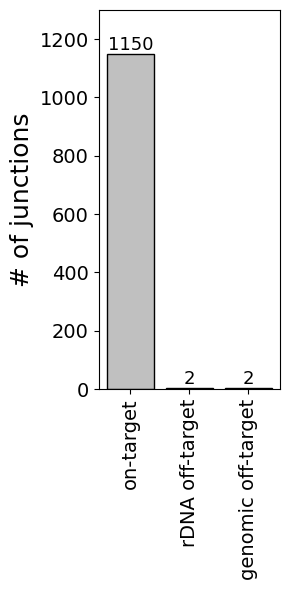

In [24]:
# check first if any on-target internal

fig = plt.figure(figsize=(3,6))
ax = fig.add_subplot(111)

labels = ['on-target','rDNA off-target', 'genomic off-target']
_3p_categories = [Counter(list(_3p_junctions.values()))[label] for label in labels]
bars = ax.bar(labels, _3p_categories, fc='silver', ec='k')
ax.bar_label(bars, fontsize=13)
ax.tick_params(labelsize=14)
ax.set_ylabel('# of junctions', fontsize=18)
ax.set_xticks(range(3),labels,rotation=90)
ax.set_ylim(0,1300)

fig.tight_layout()
fig.savefig('plots/%s_3pjunction_classifications.eps' % prefix)
fig.savefig('plots/%s_3pjunction_classifications.png' % prefix)

# 5' junctions

In [36]:
np.save('out/%s_tandem.npy' % prefix, [x for x in _5p_junctions if 'tandem' in _5p_junctions[x]])
np.save('out/%s_templatejumps.npy' % prefix, [x for x in _5p_junctions if 'TJ' in _5p_junctions[x]])

In [27]:
labels = ['FL_anneal', 'FL_join', 'FL_dup','FL_del','FL_cDNA_snapback','FL_rDNA_snapback','FL_tandem','FL_TJ','FL_other',
          'Trunc_join', 'Trunc_dup','Trunc_del','Trunc_cDNA_snapback','Trunc_rDNA_snapback','Trunc_tandem','Trunc_TJ','Trunc_other']

_5p_categories = [Counter(list(_5p_junctions.values()))[label] for label in labels]
_5p_category_dict = {label: Counter(list(_5p_junctions.values()))[label] for label in labels}

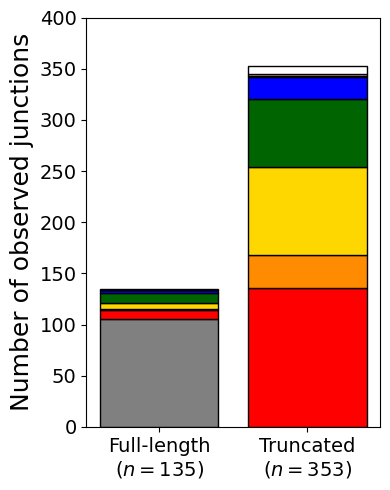

In [28]:
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)

a = ax.bar(x=[0]*9+[1]*8,
           height=_5p_categories,
           bottom=np.hstack([[0],np.cumsum(_5p_categories[:8]),[0],np.cumsum(_5p_categories[9:-1])]),
           ec='k', color=['gray', 'r','darkorange', 'gold', 'darkgreen', 'blue', 'mediumpurple', 'pink','white',
                          'r','darkorange', 'gold', 'darkgreen', 'blue', 'mediumpurple','pink','white'])
ax.set_xticks([0,1],['Full-length\n$(n=%i)$' % sum(_5p_categories[:9]),'Truncated\n$(n=%i)$' % sum(_5p_categories[9:])])
ax.tick_params(labelsize=14)
ax.set_ylabel('Number of observed junctions', fontsize=18)
ax.set_ylim(0,400)


fig.tight_layout()

fig.savefig('plots/%s_5pjunction_classifications_allcats.eps' % prefix)
fig.savefig('plots/%s_5pjunction_classifications_allcats.png' % prefix)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


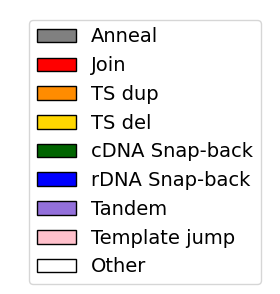

In [29]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)

ax.legend(a,['Anneal', 'Join', 'TS dup', 'TS del', 'cDNA Snap-back', 'rDNA Snap-back', 'Tandem', 'Template jump', 'Other'],
          fontsize=14)
plt.axis('off')

fig.tight_layout()
fig.savefig('plots/detailed_5pjunctions_legend.eps')
fig.savefig('plots/detailed_5pjunctions_legend.png')

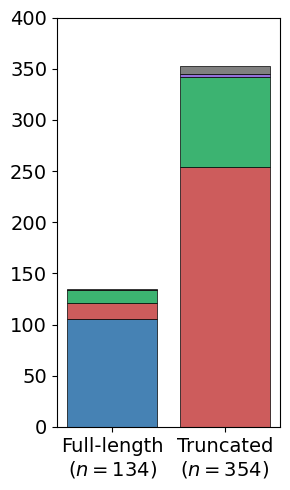

In [30]:
fig = plt.figure(figsize=(3,5))

ax = fig.add_subplot(111)
a = ax.bar(x=[0]*5+[1]*4,
           height=[_5p_category_dict['FL_anneal'],
                   _5p_category_dict['FL_join']+_5p_category_dict['FL_dup']+_5p_category_dict['FL_del'],
                   _5p_category_dict['FL_cDNA_snapback']+_5p_category_dict['FL_rDNA_snapback'],
                   _5p_category_dict['FL_tandem']+_5p_category_dict['FL_TJ'],
                   _5p_category_dict['FL_other'],
                   _5p_category_dict['Trunc_join']+_5p_category_dict['Trunc_dup']+_5p_category_dict['Trunc_del'],
                   _5p_category_dict['Trunc_cDNA_snapback']+_5p_category_dict['Trunc_rDNA_snapback'],
                   _5p_category_dict['Trunc_tandem']+_5p_category_dict['Trunc_TJ'],
                   _5p_category_dict['Trunc_other']],
           bottom=[0,
                   _5p_category_dict['FL_anneal'],
                   _5p_category_dict['FL_anneal']+_5p_category_dict['FL_join']+_5p_category_dict['FL_dup']+_5p_category_dict['FL_del'],
                   _5p_category_dict['FL_anneal']+_5p_category_dict['FL_join']+_5p_category_dict['FL_dup']+_5p_category_dict['FL_del']+_5p_category_dict['FL_cDNA_snapback']+_5p_category_dict['FL_rDNA_snapback'],
                   _5p_category_dict['FL_anneal']+_5p_category_dict['FL_join']+_5p_category_dict['FL_dup']+_5p_category_dict['FL_del']+_5p_category_dict['FL_cDNA_snapback']+_5p_category_dict['FL_rDNA_snapback']+ _5p_category_dict['FL_tandem']+_5p_category_dict['FL_TJ'],
                   0,
                   _5p_category_dict['Trunc_join']+_5p_category_dict['Trunc_dup']+_5p_category_dict['Trunc_del'],
                   _5p_category_dict['Trunc_join']+_5p_category_dict['Trunc_dup']+_5p_category_dict['Trunc_del']+_5p_category_dict['Trunc_cDNA_snapback']+_5p_category_dict['Trunc_rDNA_snapback'],
                   _5p_category_dict['Trunc_join']+_5p_category_dict['Trunc_dup']+_5p_category_dict['Trunc_del']+_5p_category_dict['Trunc_cDNA_snapback']+_5p_category_dict['Trunc_rDNA_snapback']+ _5p_category_dict['Trunc_tandem']+_5p_category_dict['Trunc_TJ']],           
            color=['steelblue','indianred','mediumseagreen','mediumpurple', 'gray',
                   'indianred','mediumseagreen','mediumpurple','gray'], ec='k', lw=0.5)
ax.set_xticks([0,1],['Full-length\n$(n=%i)$' % sum(_5p_categories[:8]),'Truncated\n$(n=%i)$' % sum(_5p_categories[8:])])
ax.tick_params(labelsize=14)
ax.set_ylim(0,400)


fig.tight_layout()

fig.savefig('plots/%s_5pjunction_classifications_simplecats.eps' % prefix)
fig.savefig('plots/%s_5pjunction_classifications_simplecats.png' % prefix)


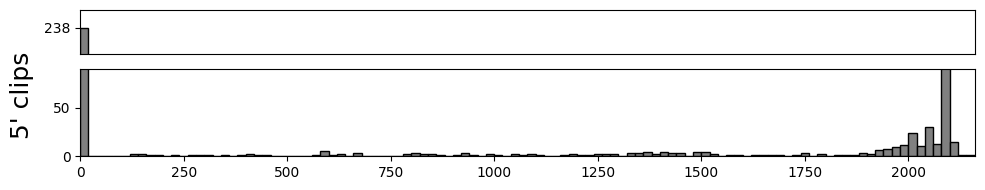

In [31]:
fig = plt.figure(figsize=(10,2))

gs = GridSpec(2, 1, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

hist = ax1.hist(np.array(tg_start_sites)-flank_len,bins=np.arange(0,2161,20), fc='gray', ec='k');
max_val = hist[0][0]
ax1.set_ylim(max_val-3,max_val+2)
ax1.set_xlim((0,2161))
ax1.set_xticks([])
ax1.set_yticks([max_val])

ax2.hist(np.array(tg_start_sites)-flank_len,bins=np.arange(0,2161,20), fc='gray', ec='k');
ax2.set_ylim(0,90)
ax2.set_xlim((0,2161))

fig.supylabel('5\' clips', fontsize=18)
fig.tight_layout()

fig.savefig('plots/%s_5pjunction_locs.eps' % prefix)
fig.savefig('plots/%s_5pjunction_locs.png' % prefix)

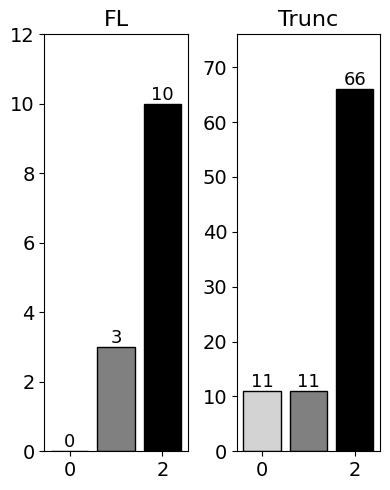

In [32]:
# split snap-backs into rDNA upstream, rDNA downstream, cDNA snap-back

rDNA_snapbacks = [x for x in _5p_junctions if 'rDNA_snapback' in _5p_junctions[x]]
FL_rDNA_snap_upstream = 0
FL_rDNA_snap_downstream = 0
Trunc_rDNA_snap_upstream = 0
Trunc_rDNA_snap_downstream = 0

for matepair in rDNA_snapbacks:
    label, read_num, up, down = opposite_strand[matepair]
    upstream = read_dict[matepair][read_num]['pt%i' % (up+1)]
    downstream = read_dict[matepair][read_num]['pt%i' % (down+1)]
    if upstream.ref_start<11679:
        if 'Trunc' in _5p_junctions[matepair]:
            Trunc_rDNA_snap_upstream += 1
        else:
            FL_rDNA_snap_upstream += 1
    else:
        if 'Trunc' in _5p_junctions[matepair]:
            Trunc_rDNA_snap_downstream += 1
        else:
            FL_rDNA_snap_downstream += 1
        
FL_cDNA_snap = len([x for x in _5p_junctions if 'FL_cDNA_snapback' in _5p_junctions[x]])
Trunc_cDNA_snap = len([x for x in _5p_junctions if 'Trunc_cDNA_snapback' in _5p_junctions[x]])

fig = plt.figure(figsize=(4,5))

ax = fig.add_subplot(121)
bars = ax.bar(range(3), height=[FL_rDNA_snap_upstream, FL_rDNA_snap_downstream, FL_cDNA_snap], ec='k', color=['lightgray','gray','black'])
ax.bar_label(bars, fontsize=13)
ax.tick_params(labelsize=14)
ax.set_title('FL', fontsize=16)
ax.set_ylim(0,12)

ax = fig.add_subplot(122)
bars = ax.bar(range(3), height=[Trunc_rDNA_snap_upstream, Trunc_rDNA_snap_downstream, Trunc_cDNA_snap], ec='k', color=['lightgray','gray','black'])
ax.bar_label(bars, fontsize=13)
ax.tick_params(labelsize=14)
ax.set_title('Trunc', fontsize=16)
ax.set_ylim(0,76)


fig.tight_layout()

fig.savefig('plots/%s_snapbacks.eps' % prefix)
fig.savefig('plots/%s_snapbacks.png' % prefix)